# CONCLUDING PART

## Machine Learning Project Part 3

#### Import libraries
Importing Required Libraries

In [18]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular
print('Done')

Done


__Read in Datasets__

In [2]:
# importing all our formated datasets
train_features = pd.read_csv(r'C:\Users\ABDULAZEEZ R.O\Desktop\ML_walk_through\data_training_features.csv')
test_features = pd.read_csv(r'C:\Users\ABDULAZEEZ R.O\Desktop\ML_walk_through\data_testing_features.csv')
train_labels = pd.read_csv(r'C:\Users\ABDULAZEEZ R.O\Desktop\ML_walk_through\data_training_labels.csv')
test_labels = pd.read_csv(r'C:\Users\ABDULAZEEZ R.O\Desktop\ML_walk_through\data_testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 65)
Testing Feature Size:   (2839, 65)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


__Recreate Final Model__

In [3]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [5]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 8.9261


### Let's Interpret the model

We will explore several ways to interpret our model:

1. Feature importances
2. Locally Interpretable Model-agnostic Explainer (LIME)

## 1. Feature Importances

One of the basic ways we can interpret an ensemble of decision trees is through what are known as the feature importances. These can be interpreted as the variables which are most predictive of the target. We can use the relative values to compare the features and determine which are most relevant to our problem.

Extracting the feature importances from a trained ensemble of trees is quite easy in scikit-learn. We will store the feature importances in a dataframe to analyze and visualize them.

In [8]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site_EUI_(kBtu/ft²),0.608789
1,Largest_Property_Use_Type_Multifamily Housing,0.150258
2,Weather_Normalized_Site_Electricity_Intensity_...,0.063437
3,Property_Id,0.022914
4,DOF_Gross_Floor_Area,0.022134
5,log_Direct_GHG_Emissions_(Metric_Tons_CO2e),0.015266
6,Year_Built,0.013394
7,BBL_-_10_digits,0.013116
8,Latitude,0.012223
9,Longitude,0.011405


The Site Energy Use Intensity, Site EUI (kBtu/ft²), and the Largest_Property_Use_Type_Multifamily Housing are the two most important features by quite a large margin. After that, the relative importance drops off considerably which indicates that we might not need to retain all of the features to create a model with nearly the same performance.

Let's graph the feature importances to compare visually.

<Figure size 864x1080 with 0 Axes>

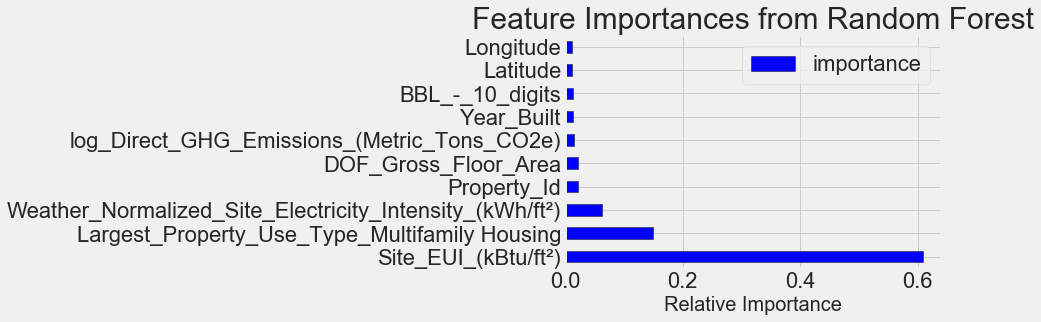

In [11]:
plt.figure(figsize =(12, 15))
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

__Use Feature Importances for Feature Selection__

Given that not every feature is important for finding the score, what would happen if we used a simpler model, such as a linear regression, with the subset of most important features from the random forest? The linear regression did outperform the baseline, but it did not perform well compared to the model complex models. Let's try using only the 10 most important features in the linear regression to see if performance is improved. We can also limit to these features and re-evaluate the random forest.

In [12]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [13]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4594.
Linear Regression Reduced Results: MAE = 14.8294.


Well, reducing the features did not improve the linear regression results! It turns out that the extra information in the features with low importance do actually improve performance.

Let's look at using the reduced set of features in the gradient boosted regressor. How is the performance affected?

In [14]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.5492


The model results are slightly worse with the reduced set of features and we will keep all of the features for the final model. The desire to reduce the number of features is because we are always looking to build the most parsimonious model: that is, the simplest model with adequate performance. A model that uses fewer features will be faster to train and generally easier to interpret. In this case, keeping all of the features is not a major concern because the training time is not significant and we can still make interpretations with many features.

## 2. Locally Interpretable Model-agnostic Explanations

LIME is a relatively new effort aimed at showing how a machine learning model thinks by approximating the region around a prediction with a linear model.

We will look at trying to explain the predictions on an example the model gets very wrong and an example the model gets correct. We will restrict ourselves to using the reduced set of 10 features to aid interpretability. The model trained on the 10 most important features is slightly less accurate, but we generally have to trade off accuracy for interpretability!

In [15]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [19]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 13.1681
Actual Value: 100.0000


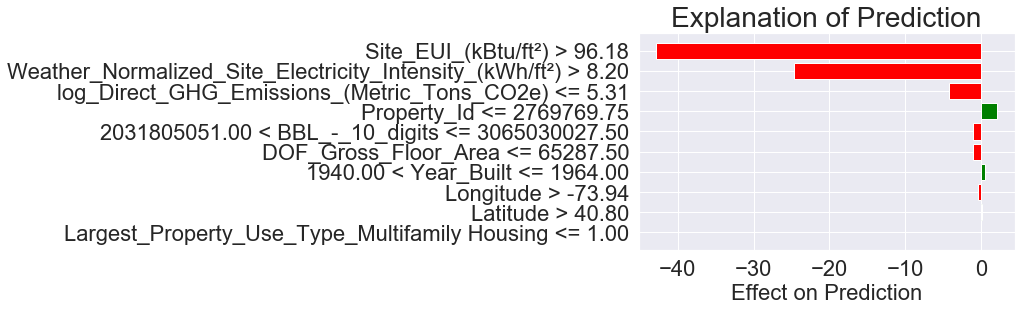

In [20]:

# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);


In this example, our gradient boosted model predicted a score of 13.17 and the actual value was 100.

The plot from LIME is showing us the contribution to the final prediction from each of the features for the example. We can see that the Site EUI singificantly decreased the prediction because it was above 96.18. The Weather Normalized Site Electricity Intensity on the other hand, decreased the prediction as well because it was above 8.20.

We can interpret this as saying that our model thought the Energy Star Score would be much lower than it actually was because the Site EUI was high. However, in this case, the score was 100 despite the high value of the EUI. While this significant mistake (off by 88 points!) might initially have been confusing, now we can see that in reality, the model was reasoning through the problem and just arrived at the incorrect value! A human going over the same process probably would have arrived at the same conclusion (if they had the patience to go through all the data).

Now we can go through the same process with a prediction the model got correct.

Prediction: 100.0000
Actual Value: 100.0000


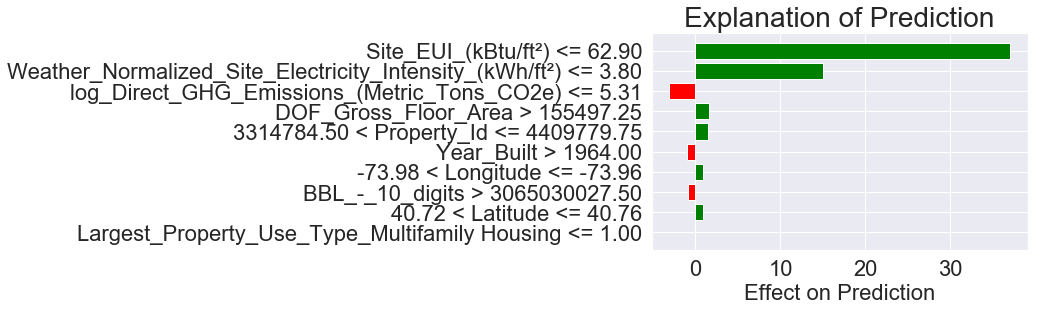

In [21]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

The correct value for this case was 100 which our gradient boosted model got right on!

The plot from LIME again shows the contribution to the prediciton of each of feature variables for the example. For instance, because the Site EUI was less than 62.90, that contributed significantly to a higher estimate of the score. Likewise, Weather_Normalized_Site_Electricity_intensity being less than 3.80 also positively contributed to the final prediction

Observing break down plots like these allow us to get an idea of how the model makes a prediction. This is probably most valuable for cases where the model is off by a large amount as we can inspect the errors and perhaps engineer better features or adjust the hyperparameters of the model to improve predictions for next time. The examples where the model is off the most could also be interesting edge cases to look at manually. The model drastically underestimated the Energy Star Score for the first building because of the elevated Site EUI. We might therefore want to ask why the building has such a high Energy Star Score even though it has such a high EUI. A process such as this where we try to work with the machine learning algorithm to gain understanding of a problem seems much better than simply letting the model make predictions and completely trusting them! Although LIME is not perfect, it represents a step in the right direction towards explaining machine learning models.

## Conclusions and Document Findings

The final part of the machine learning pipeline might be the most important: we need to compress everything we have learned into a short summary highlighting only the most crucial findings. Here are my top 2 designed to be communicated in 30 seconds:

1. Using the given building energy data, a machine learning model can predict the Energy Star Score of a building to within 10 points.
2. The most important variables for determining the Energy Star Score are the Energy Use Intensity, Electricity Use Intensity, and the Water Use Intensity

I think it's time for us to wrap up this project! I had a great time writing these notebooks and doing the analysis, and I hope you enjoyed reading this and now feel more confident in implementing your own machine learning project. If you want, you can start by modifying this project and trying to beat my models! Remember, don't feel like you have to go it alone: there are plenty of amazing machine learning resources out there, and coming from someone who is entirely self-taught thanks to the great data science community, the best way to learn is to get involved and start putting your work out there!